# Taskforce to help diagnose COVID19
Kaggle competition: https://www.kaggle.com/dataset/e626783d4672f182e7870b1bbe75fae66bdfb232289da0a61f08c2ceb01cab01/data
Team members:
* [Jairo da Silva Freitas Júnior](https://www.linkedin.com/in/jairofreitas), Computer Scientist from Federal University of ABC (Brazil) and data analytst at Itaú Unibanco (Fortune 500, NYSE and B3: ITUB)
* [Christian Espinoza](https://www.linkedin.com/in/christianespinoz), Computer Scientist from University of São Caetano do Sul  (Brazil) and improver data analyst at Hospital Israelita Albert Einstein.

## Introduction

We analyse feature bias through severity of cases. 6 groups of tests were found using Principal Components Analysis. 3 of them are: Regular blood test, respiratory virus and bacterial tests and Influenza rapid tests). For these we fit models and compare the ones that favors precision and recall through a clinical perspective. Regular blood tests were found to be the most useful to detect coronavirus. We also backtest our best models agains patients infected with H1N1, Rhinovirus and Influenza B and found that our models capture SARS-CoV-2 patterns different than these flus.

Our work is organized as follows:

1. Data prep
  1. Import and preparation
  1. EDA
1. Modelling strategy
1. Prediction of confirmed COVID19
  1. Regular blood Tests
    1. Baseline
    1. SVM
    1. Gradient Boosting Classifier
        1. Backtest against Influenza B
        1. Backtest against H1N1
        1. Backtest against Rhinovirus
    1. Random Forest
    1. AdaBoost (on Decision Trees)
        1. Backtest against Influenza B
        1. Backtest against H1N1
        1. Backtest against Rhinovirus
  1. Respiratory virus and bacteria Tests
    1. Baseline
    1. SVM
    1. Gradient Boosting Classifier
    1. Random Forest
    1. AdaBoost (on Decision Trees)
  1. Influenza 
    1. Baseline
    1. SVM
    1. Gradient Boosting Classifier
    1. Random Forest
    1. AdaBoost (on Decision Trees)
1. Discussion of results
1. Acknowledgment

## Data prep


### Import

We performed categorical to numerical conversion and removed  tests that were not tested on infected patients. Both data preparations are inspired by Ossamu's[1] EDA of this dataset. Different from him, we considered wordings like "not_done" and "Não Realizado" as missing for further analysis of missing values. We also treated "Ausentes" as 0 and any other kind of crystal as 1 on "Urine - Crystals", because we believe that this is more intuitive for interpretation.

In [34]:
import pandas as pd
import numpy as np

In [35]:
df = pd.read_csv('dataset.csv')

In [36]:
df.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
print("This dataset has {:.1f}".format(100*df.isna().to_numpy().sum()/(df.shape[0]*df.shape[1])) + "% missing values")

This dataset has 88.1% missing values


In [38]:
#Encode the addmission columns into one
df2 = df.copy()

def unit_room(x):
    if x['Patient addmited to regular ward (1=yes, 0=no)']>0:
        return 'regular ward'
    elif x['Patient addmited to semi-intensive unit (1=yes, 0=no)']>0:
        return 'semi-intensive'
    elif x['Patient addmited to intensive care unit (1=yes, 0=no)']>0:
        return 'icu'
    else:
        return 'elective'

df2['unit'] = df2.apply(unit_room, axis=1)

In [39]:
df2[['Patient addmited to regular ward (1=yes, 0=no)', 
     'Patient addmited to semi-intensive unit (1=yes, 0=no)',
     'Patient addmited to intensive care unit (1=yes, 0=no)',
     'unit']].head(10)

,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",unit
0,0,0,0,elective
1,0,0,0,elective
2,0,0,0,elective
3,0,0,0,elective
4,0,0,0,elective
5,0,0,0,elective
6,0,0,0,elective
7,0,0,0,elective
8,0,1,0,semi-intensive
9,0,0,0,elective


In [40]:
#Conversion from categorical to numerical
mask = {'positive': 1, 
        'negative': 0,
        'detected': 1, 
        'not_detected': 0,
        'not_done': np.NaN,
        'Não Realizado': np.NaN,
        'absent': 0, 
        'present': 1,
        'detected': 1, 
        'not_detected': 0,
        'normal': 1,
        'light_yellow': 1, 
        'yellow': 2, 
        'citrus_yellow': 3, 
        'orange': 4,
        'clear': 1, 
        'lightly_cloudy': 2, 
        'cloudy': 3, 
        'altered_coloring': 4,
        '<1000': 1000,
        'Ausentes': 0, 
        'Urato Amorfo --+': 1, 
        'Oxalato de Cálcio +++': 1,
        'Oxalato de Cálcio -++': 1, 
        'Urato Amorfo +++': 1}

df3 = df2.copy()
df3 = df2.replace(mask)

df3['Urine - pH'] = df3['Urine - pH'].astype('float')
df3['Urine - Leukocytes'] = df3['Urine - Leukocytes'].astype('float')

In [41]:
#Removal of exams not performed on positive cases
exams_cols = df3.columns.to_list()[6:-1]

is_null_columns_covid = df3[df3['SARS-Cov-2 exam result']==1][exams_cols].apply(lambda col: col.isnull().all(), axis=0)
all_null_columns_covid = is_null_columns_covid[is_null_columns_covid==True]

In [42]:
print("Exams not performed on positive cases, so they are uninformative:\n")
print(all_null_columns_covid.index)

Exams not performed on positive cases, so they are uninformative:

Index(['Mycoplasma pneumoniae', 'Fio2 (venous blood gas analysis)',
       'Urine - Nitrite', 'Urine - Sugar',
       'Partial thromboplastin time (PTT) ', 'Prothrombin time (PT), Activity',
       'Vitamin B12', 'D-Dimer', 'Albumin'],
      dtype='object')


In [43]:
df4 = df3[set(df3.columns)-set(all_null_columns_covid.index)].copy()
exams_cols = set(exams_cols) - set(all_null_columns_covid.index)

### EDA

We first analyze the frequency of each test in the dataset. The first plot in the figure below illustrate it (Figure 1 (a)). There's a high dispersion in the quantity of patients undergoing each test. So we investigated (Figure 1 (b)) the representativeness of patient admission unit for each medical exam. Usually, rarest tests are related to increased complexity of the medical facility. Also, we found on Figure 1 (c) that rarer tests are related to higher probability of the patient having coronavirus.

In [44]:
exams_performed = (-df4[exams_cols].isnull()).astype('uint8')

In [45]:
exams_performed.head()

,Hb saturation (arterial blood gases),pCO2 (venous blood gas analysis),Urine - Density,Influenza A,Basophils,Magnesium,Myelocytes,HCO3 (arterial blood gas analysis),Parainfluenza 1,Urine - pH,...,Total CO2 (arterial blood gas analysis),Red blood cell distribution width (RDW),Urine - Crystals,Monocytes,Rhinovirus/Enterovirus,Serum Glucose,Urine - Aspect,Phosphor,Urine - Protein,Parainfluenza 2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,0,0,1,0,...,0,1,0,1,1,1,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1


In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

[]

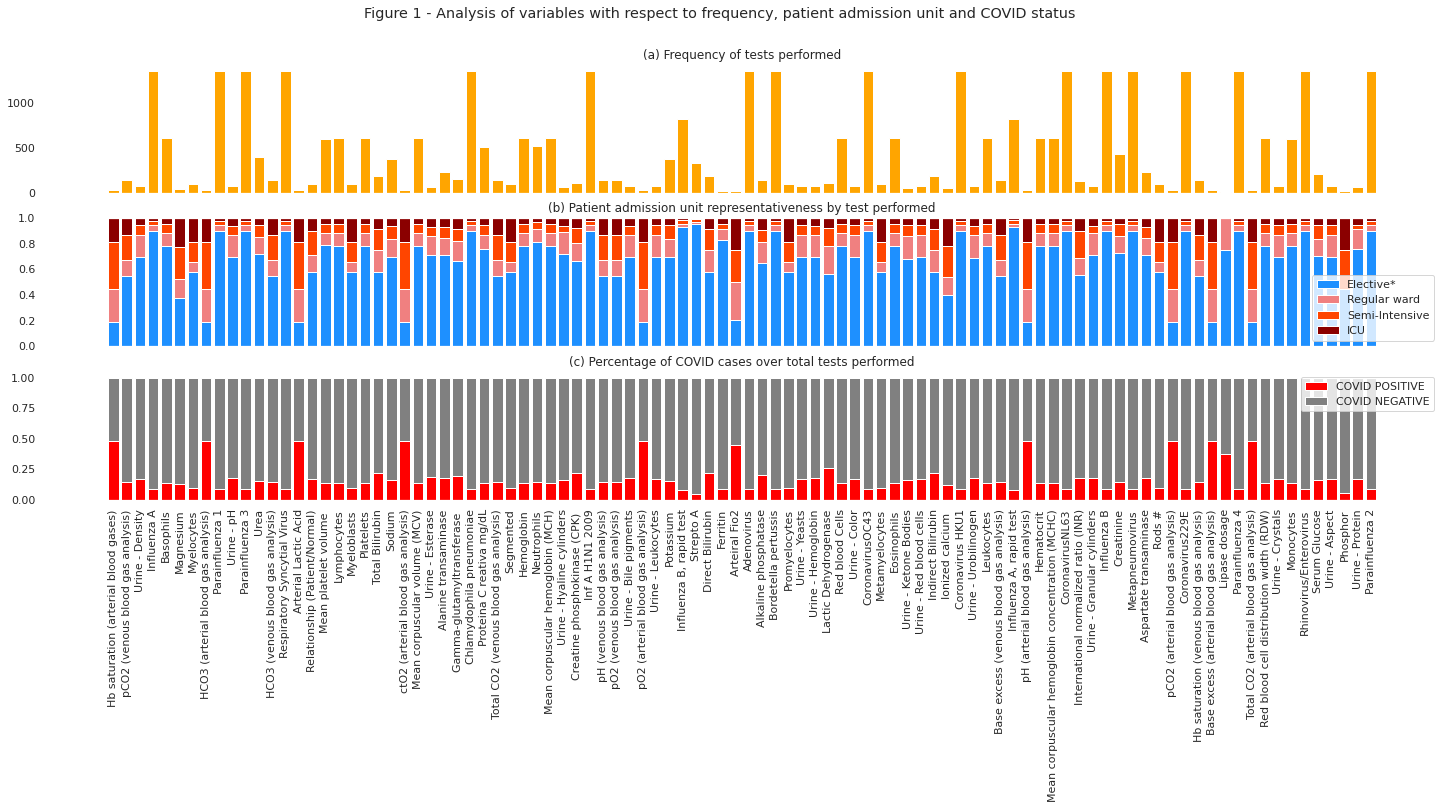

In [47]:
exams_cols_list = list(exams_cols)
freqExams = df4.shape[0] - df4[exams_cols_list].isnull().sum()

covY = (df4[df4['SARS-Cov-2 exam result']==1].shape[0]
        -df4[df4['SARS-Cov-2 exam result']==1][exams_cols_list].isnull().sum())/(df4.shape[0] - df4[exams_cols_list].isnull().sum())
covN = (df4[df4['SARS-Cov-2 exam result']==0].shape[0]
        -df4[df4['SARS-Cov-2 exam result']==0][exams_cols_list].isnull().sum())/(df4.shape[0] - df4[exams_cols_list].isnull().sum())

examsICU = (df4[df4['unit']=='icu'].shape[0]
        -df4[df4['unit']=='icu'][exams_cols_list].isnull().sum())/(df4.shape[0] - df4[exams_cols_list].isnull().sum())
examsSemiIntesive = (df4[df4['unit']=='semi-intensive'].shape[0]
        -df4[df4['unit']=='semi-intensive'][exams_cols_list].isnull().sum())/(df4.shape[0] - df4[exams_cols_list].isnull().sum())
examsRegular = (df4[df4['unit']=='regular ward'].shape[0]
        -df4[df4['unit']=='regular ward'][exams_cols_list].isnull().sum())/(df4.shape[0] - df4[exams_cols_list].isnull().sum())
examsElective = (df4[df4['unit']=='elective'].shape[0]
        -df4[df4['unit']=='elective'][exams_cols_list].isnull().sum())/(df4.shape[0] - df4[exams_cols_list].isnull().sum())

fig, axs = plt.subplots(3, 1, figsize=(25,8))
fig.patch.set_facecolor('white')

#Frequency plot
pFreq = axs[0].bar(exams_cols_list, freqExams, color='orange', )  
axs[0].set_title("(a) Frequency of tests performed")
axs[0].get_xaxis().set_ticks([])

#Admission units over total tests performed
pElective = axs[1].bar(exams_cols_list, examsElective, color='dodgerblue')
pRegular = axs[1].bar(exams_cols_list, examsRegular, bottom=examsElective,  color='lightcoral')
pSemiIntesive = axs[1].bar(exams_cols_list, examsSemiIntesive, bottom=(examsElective+examsRegular), color='orangered')
pICU = axs[1].bar(exams_cols_list, examsICU, bottom=(examsSemiIntesive+examsElective+examsRegular), color='darkred')
axs[1].set_title("(b) Patient admission unit representativeness by test performed")
axs[1].legend(["Elective*", "Regular ward", "Semi-Intensive", "ICU"], loc="lower right")
axs[1].get_xaxis().set_ticks([])

#Percentage of COVID cases over total tests performed
pCovY = axs[2].bar(exams_cols_list, covY, color='red')
pCovN = axs[2].bar(exams_cols_list, covN, bottom=covY, color='grey')
plt.xticks(exams_cols_list, exams_cols_list, rotation='vertical')
axs[2].set_title("(c) Percentage of COVID cases over total tests performed")
axs[2].legend(["COVID POSITIVE", "COVID NEGATIVE"])

plt.xticks(exams_cols_list, exams_cols_list, rotation='vertical')

plt.subplots_adjust(hspace=0.2) 
fig.suptitle("Figure 1 - Analysis of variables with respect to frequency, patient admission unit and COVID status")
plt.plot()

Given the high dispersion of patients undergoing each test, we also analysed the null values in the dataset. Figure 2 is based on Nasser Boan's kernel [2]. Unfortunately, he didn't report the interpretation of the pattern in the data, so we will do it by performing dimensionality reduction on the presence (or absence) of exams. For that we used the standart implementation of PCA from Scikit-learn.

Text(0.5, 1.0, 'Figure 2 - Presence (white) or absense (black) of exams')

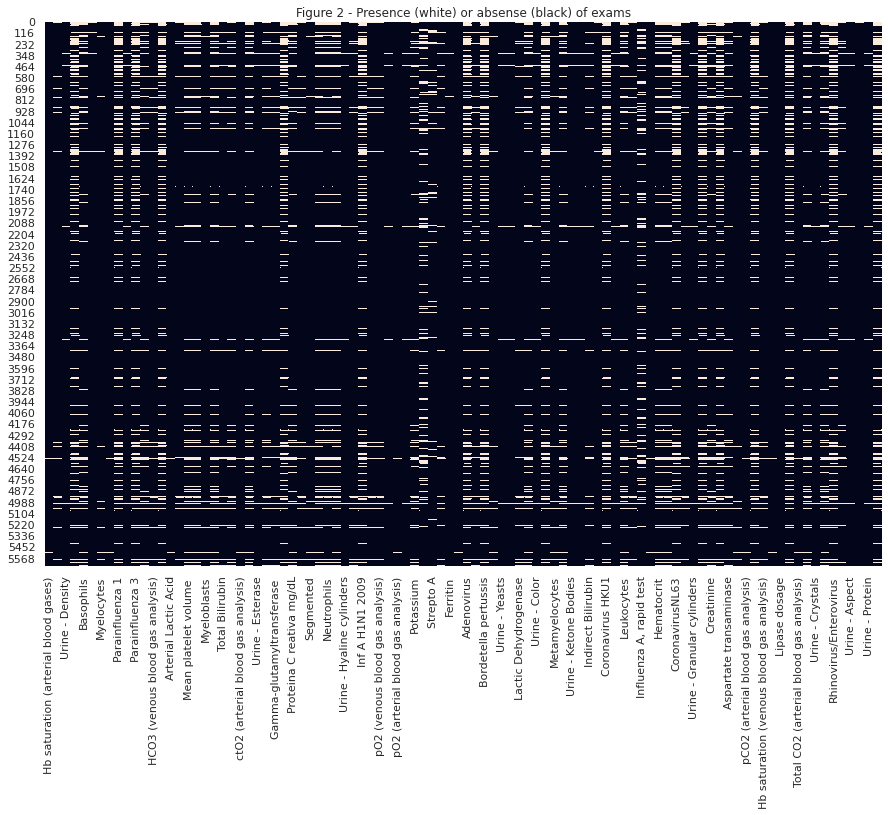

In [48]:
plt.figure(figsize=(15,10))
sns.heatmap(exams_performed, cbar=False)
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
plt.title("Figure 2 - Presence (white) or absense (black) of exams")

From Figure 3 we observe that after the 6th component the variance explained grows very slowly. On Figure 4 we plot the most important features of the first 6 principal components (variance explained by these PCs: 94%). Later we interpret these PCs.

In [49]:
from sklearn.decomposition import PCA

In [50]:
pca_model = PCA(random_state=42).fit(exams_performed)

Text(0.5, 1.0, 'Figure 3 - Cummulative explained variance of Principal Components')

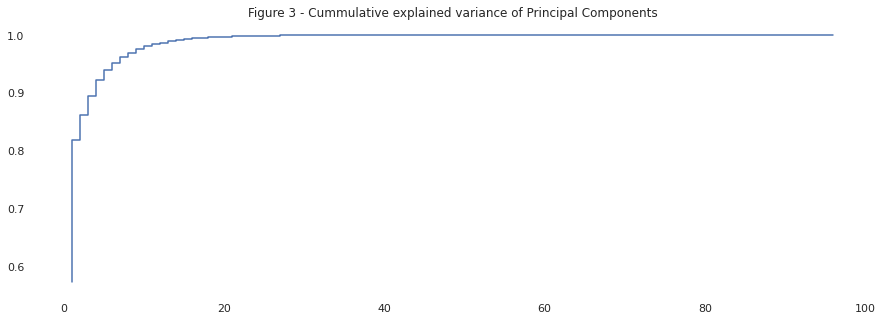

In [51]:
%matplotlib inline
variances_explained = pca_model.explained_variance_ratio_.cumsum()
fig = plt.figure(figsize=(15,5))
fig.patch.set_facecolor('white')
plt.step(list(range(1,len(variances_explained)+1)),variances_explained)
plt.title("Figure 3 - Cummulative explained variance of Principal Components")

In [52]:
variances_explained

array([0.5724812 , 0.81883003, 0.86069827, 0.89442569, 0.92251971,
       0.93859529, 0.95121399, 0.96098439, 0.96878939, 0.97621242,
       0.98071415, 0.98391142, 0.98651966, 0.98861734, 0.99061927,
       0.99242062, 0.99401144, 0.99526779, 0.99602428, 0.99660657,
       0.99703934, 0.99743371, 0.99775496, 0.9980632 , 0.9983323 ,
       0.9985854 , 0.99879539, 0.99899706, 0.99915314, 0.99929859,
       0.99943423, 0.99956434, 0.99967103, 0.99976421, 0.99983115,
       0.99988037, 0.9999273 , 0.9999527 , 0.99997143, 0.99998599,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [53]:
pca_model = PCA(n_components=6, random_state=42).fit(exams_performed)

Text(0.5, 0.98, 'Figure 4 - Principal Components (PC) explained')

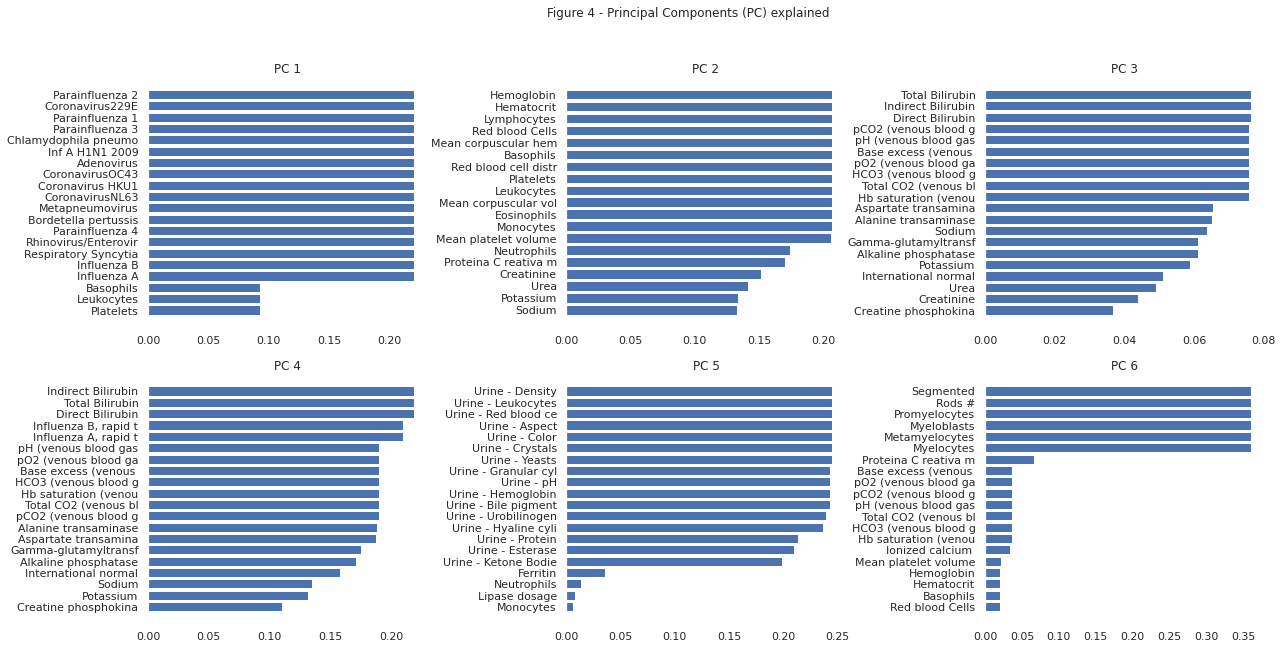

In [54]:
fig, axs = plt.subplots(2, 3, figsize=(20,10))
fig.patch.set_facecolor((1,1,1))
plt.subplots_adjust(wspace=0.5) 
pc=-1
for i in list(range(2)): #plot lines
  for j in list(range(3)): #plot cols
    pc+=1
    component_feature_explanation = pd.Series(pca_model.components_[pc], index=list(exams_cols)).sort_values()
    axis_truncated = [txt[:20] for txt in component_feature_explanation[-20:].index]
    axs[i, j].barh(axis_truncated, component_feature_explanation[-20:])
    axs[i, j].set_title('PC '+str(pc+1))
fig.suptitle("Figure 4 - Principal Components (PC) explained")

The interpretation of the first six principal components are:
1. Respiratory viruses test (e.g.: Influenza, Rhinovirus)
2. Regular blood test (red and white cells)
3. Billirubin, enzymes, electrolytes<sup>1</sup> and gaseous analysis
4. Same interpretation of 3 (medical expertise would help)
5. Urine
6. Unusual Bone marrow cells circulating in blood and segmented parts

<sup>1</sup> We found Blann article on Nursing Times [3] useful to feel comfortable deciding to allocate electrolytes on PC 3 other than 2 (which is in accordance to the data).

Some models do not accept null values. Inputation in the medical context is hard and must consider demographic characteristics (like gender, race, etc.) that are not provided in the dataset. **The result above can be helpful to fit partial models on chunks of exams available (since we observed that some of them occur together).**



In [55]:
pcs_vars = {'respiratory': ['Influenza B', 'Respiratory Syncytial Virus', 'Influenza A',
                            'Metapneumovirus', 'Parainfluenza 1', 'Inf A H1N1 2009',
                            'Bordetella pertussis', 'Chlamydophila pneumoniae', 'Coronavirus229E',
                            'Parainfluenza 2', 'Parainfluenza 3', 'CoronavirusNL63',
                            'Rhinovirus/Enterovirus', 'CoronavirusOC43', 'Coronavirus HKU1',
                            'Adenovirus', 'Parainfluenza 4'],
            'regular_blood': ['Proteina C reativa mg/dL',
                              'Neutrophils', 'Mean platelet volume ', 'Monocytes',
                              'Red blood cell distribution width (RDW)', 'Red blood Cells',
                              'Platelets', 'Eosinophils', 'Basophils', 'Leukocytes',
                              'Mean corpuscular hemoglobin (MCH)', 'Mean corpuscular volume (MCV)',
                              'Mean corpuscular hemoglobin concentration\xa0(MCHC)', 'Lymphocytes',
                              'Hemoglobin', 'Hematocrit'],
            'liver_kidney_gas': ['Creatine phosphokinase\xa0(CPK)\xa0', 
                                 'International normalized ratio (INR)', 
                                 'Alkaline phosphatase', 'Gamma-glutamyltransferase\xa0',
                                 'Alanine transaminase', 'Aspartate transaminase',
                                 'HCO3 (venous blood gas analysis)',
                                 'Hb saturation (venous blood gas analysis)',
                                 'Total CO2 (venous blood gas analysis)',
                                 'pCO2 (venous blood gas analysis)', 'pH (venous blood gas analysis)',
                                 'pO2 (venous blood gas analysis)',
                                 'Base excess (venous blood gas analysis)', 'Total Bilirubin',
                                 'Direct Bilirubin', 'Indirect Bilirubin',
                                 'Sodium', 'Potassium', 'Urea', 'Creatinine'],
            'urine': ['Urine - Ketone Bodies', 'Urine - Esterase', 'Urine - Protein',
                      'Urine - Hyaline cylinders', 'Urine - Urobilinogen',
                      'Urine - Bile pigments', 'Urine - Hemoglobin', 'Urine - pH',
                      'Urine - Granular cylinders', 'Urine - Aspect', 'Urine - Density',
                      'Urine - Color', 'Urine - Red blood cells', 'Urine - Leukocytes',
                      'Urine - Yeasts', 'Urine - Crystals'],
            'bone_narrow_cells': ['Metamyelocytes', 'Myelocytes', 'Promyelocytes', 'Rods #',
                                  'Myeloblasts', 'Segmented'],
            'influenza_rapid': ['Influenza B, rapid test', 'Influenza A, rapid test']}

vars_analyzed = [var for pc in pcs_vars for var in pcs_vars[pc]]
#len(vars_analyzed) == len(set(vars_analyzed)) #sanity check must return true
#len(vars_analyzed) #Output: 77

In [56]:
df5 = df4.copy()
#Here we create columns to flag the group of tests performed
for pc in pcs_vars.keys():
  df5[pc+"_tests"] = df5.apply(lambda x: 0 if x[pcs_vars[pc]].isnull().all() else 1,axis=1)

We merged PCs 3 and 4. We also created a group containing the influenza rapid tests (these exams are not present in the PC analysis because don't co-occur with others, but are relatively commom in the dataset.

Notice that 22 tests were not included in the 6 major groups proposed . On Figure 5 we plot the frequency of these exams. They are usually very low frequency tests. 

[]

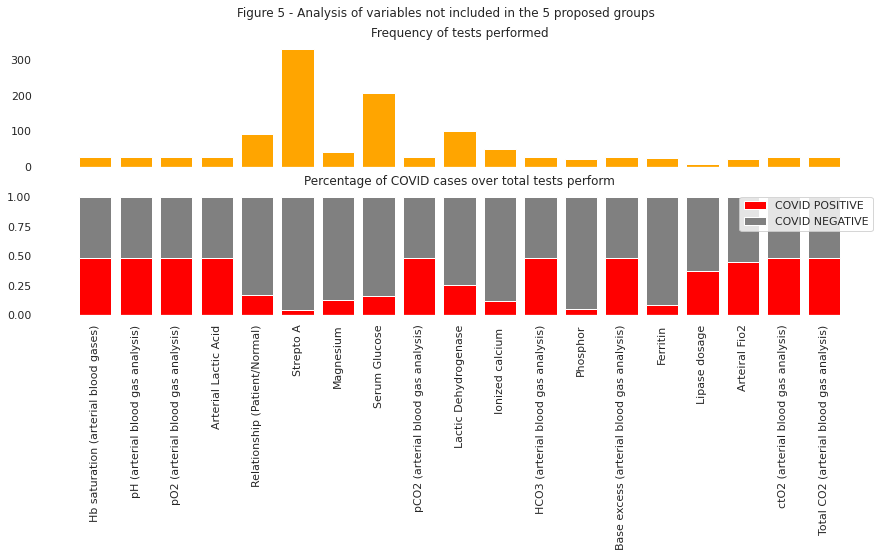

In [57]:
exams_not_included = list(set(exams_performed.columns) - set(vars_analyzed))

freqExams = df5.shape[0] - df5[exams_not_included].isnull().sum()
covY = (df5[df5['SARS-Cov-2 exam result']==1].shape[0]
        -df5[df5['SARS-Cov-2 exam result']==1][exams_not_included].isnull().sum())/(df5.shape[0] - df5[exams_not_included].isnull().sum())
covN = (df5[df5['SARS-Cov-2 exam result']==0].shape[0]
        -df5[df5['SARS-Cov-2 exam result']==0][exams_not_included].isnull().sum())/(df5.shape[0] - df5[exams_not_included].isnull().sum())


fig, axs = plt.subplots(2, 1, figsize=(15,5))


pFreq = axs[0].bar(exams_not_included, freqExams, color='orange', )  
pCovY = axs[1].bar(exams_not_included, covY, color='red')
pCovN = axs[1].bar(exams_not_included, covN, bottom=covY, color='grey')
axs[0].get_xaxis().set_ticks([])
plt.xticks(exams_not_included, exams_not_included, rotation='vertical')
axs[0].set_title("Frequency of tests performed")
axs[1].set_title("Percentage of COVID cases over total tests perform")
plt.legend(["COVID POSITIVE", "COVID NEGATIVE"])
plt.subplots_adjust(hspace=0.2) 

fig.suptitle("Figure 5 - Analysis of variables not included in the 5 proposed groups")
plt.plot()

We reordered Figure 2 rows and columns by the groups of exams. The result is shown in Figure 6. The aggregation of white points in the image illustrates the final result of PCA. Now we notice that most of the patients didn't underwent tests other then for COVID in the sample.

Text(0.5, 1.0, 'Figure 6 - Figure 2 reordered by group of exams')

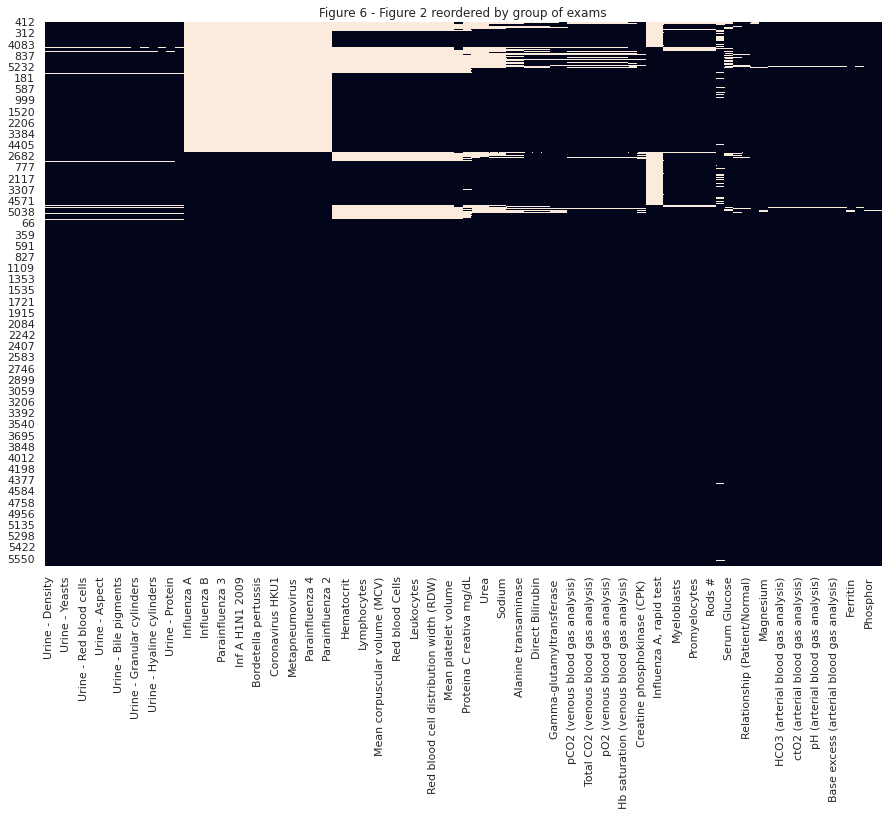

In [58]:
inv_pcs_vars = {}
for pc in pcs_vars:
    for var in pcs_vars[pc]:
        inv_pcs_vars[var]=pc

cols_sorted = pd.DataFrame(data = exams_performed.sum(), columns=["count"]).merge(
    pd.DataFrame(data = pd.Series(inv_pcs_vars), columns=["pc"]), how="left", left_index=True, 
    right_index=True).sort_values(by=["pc","count"],ascending=False)

rows_order_by = cols_sorted.reset_index().groupby("pc").first().sort_values(by=["count"],ascending=False)["index"].to_list()
#rows_order_by = ['Respiratory Syncytial Virus', 'Hematocrit', 'Influenza B, rapid test','Creatinine', 'Segmented', 'Urine - Red blood cells']

exams_performed_sorted = exams_performed[cols_sorted.index].sort_values(by=rows_order_by, ascending=False)

plt.figure(figsize=(15,10))
sns.heatmap(exams_performed_sorted, cbar=False)
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
plt.title("Figure 6 - Figure 2 reordered by group of exams")

We also performed an analysis on the co-occurences of the aforementioned groups of tests by COVID status (positive or negative) and admission unit (ICU, etc.). Below we present the data. The values are on percentage of total records of the subset of patients. We've found that infected patients have done slightly more non-respiratory tests then COVID negative people. Comparing admission units, admitted patients underwent significantly more exams then elective ones.

In [59]:
def cooc_matrix(dataset):
  cooc =  dataset.T.dot(dataset)/dataset.shape[0]
  cooc_format = cooc.style.format("{:.1%}")
  return cooc_format

tests_cols = ['respiratory_tests', 'regular_blood_tests', 
              'liver_kidney_gas_tests', 'urine_tests', 'bone_narrow_cells_tests',
              'influenza_rapid_tests']

cooc_tests_covid_neg = cooc_matrix(df5[df5['SARS-Cov-2 exam result']==0][tests_cols])
cooc_tests_covid_poz = cooc_matrix(df5[df5['SARS-Cov-2 exam result']==1][tests_cols])
cooc_tests_icu = cooc_matrix(df5[df5['unit']=='icu'][tests_cols])
cooc_tests_semi = cooc_matrix(df5[df5['unit']=='semi-intensive'][tests_cols])
cooc_tests_reg = cooc_matrix(df5[df5['unit']=='regular ward'][tests_cols])
cooc_tests_ele = cooc_matrix(df5[df5['unit']=='elective'][tests_cols])

Coocurence matrix for test on COVID negative patients:

In [60]:
cooc_tests_covid_neg

,respiratory_tests,regular_blood_tests,liver_kidney_gas_tests,urine_tests,bone_narrow_cells_tests,influenza_rapid_tests
respiratory_tests,24.4%,6.2%,5.0%,0.6%,1.1%,4.9%
regular_blood_tests,6.2%,10.3%,7.6%,0.9%,1.7%,3.4%
liver_kidney_gas_tests,5.0%,7.6%,7.6%,0.8%,1.4%,2.5%
urine_tests,0.6%,0.9%,0.8%,1.1%,0.2%,0.3%
bone_narrow_cells_tests,1.1%,1.7%,1.4%,0.2%,1.7%,0.7%
influenza_rapid_tests,4.9%,3.4%,2.5%,0.3%,0.7%,14.9%


Coocurence matrix for test on COVID positive patients:

In [61]:
cooc_tests_covid_poz

,respiratory_tests,regular_blood_tests,liver_kidney_gas_tests,urine_tests,bone_narrow_cells_tests,influenza_rapid_tests
respiratory_tests,20.1%,9.3%,9.0%,1.3%,0.7%,3.4%
regular_blood_tests,9.3%,15.1%,12.0%,1.6%,1.6%,4.1%
liver_kidney_gas_tests,9.0%,12.0%,12.0%,1.6%,1.4%,3.0%
urine_tests,1.3%,1.6%,1.6%,2.2%,0.2%,0.5%
bone_narrow_cells_tests,0.7%,1.6%,1.4%,0.2%,1.6%,0.5%
influenza_rapid_tests,3.4%,4.1%,3.0%,0.5%,0.5%,11.1%


Coocurence matrix for test on UCI patients:

In [62]:
cooc_tests_icu

,respiratory_tests,regular_blood_tests,liver_kidney_gas_tests,urine_tests,bone_narrow_cells_tests,influenza_rapid_tests
respiratory_tests,80.5%,53.7%,46.3%,7.3%,34.1%,24.4%
regular_blood_tests,53.7%,70.7%,53.7%,9.8%,43.9%,19.5%
liver_kidney_gas_tests,46.3%,53.7%,53.7%,7.3%,34.1%,12.2%
urine_tests,7.3%,9.8%,7.3%,9.8%,7.3%,4.9%
bone_narrow_cells_tests,34.1%,43.9%,34.1%,7.3%,43.9%,14.6%
influenza_rapid_tests,24.4%,19.5%,12.2%,4.9%,14.6%,31.7%


Coocurence matrix for test on semi-intensive patients:

In [63]:
cooc_tests_semi

,respiratory_tests,regular_blood_tests,liver_kidney_gas_tests,urine_tests,bone_narrow_cells_tests,influenza_rapid_tests
respiratory_tests,82.0%,68.0%,66.0%,6.0%,24.0%,36.0%
regular_blood_tests,68.0%,84.0%,80.0%,10.0%,30.0%,36.0%
liver_kidney_gas_tests,66.0%,80.0%,80.0%,10.0%,26.0%,32.0%
urine_tests,6.0%,10.0%,10.0%,10.0%,4.0%,2.0%
bone_narrow_cells_tests,24.0%,30.0%,26.0%,4.0%,30.0%,18.0%
influenza_rapid_tests,36.0%,36.0%,32.0%,2.0%,18.0%,48.0%


Coocurence matrix for test on regular ward patients:

In [64]:
cooc_tests_reg

,respiratory_tests,regular_blood_tests,liver_kidney_gas_tests,urine_tests,bone_narrow_cells_tests,influenza_rapid_tests
respiratory_tests,73.4%,59.5%,58.2%,13.9%,6.3%,12.7%
regular_blood_tests,59.5%,74.7%,72.2%,13.9%,10.1%,16.5%
liver_kidney_gas_tests,58.2%,72.2%,72.2%,13.9%,8.9%,15.2%
urine_tests,13.9%,13.9%,13.9%,15.2%,1.3%,2.5%
bone_narrow_cells_tests,6.3%,10.1%,8.9%,1.3%,10.1%,2.5%
influenza_rapid_tests,12.7%,16.5%,15.2%,2.5%,2.5%,21.5%


Coocurence matrix for test on elective patients:

In [65]:
cooc_tests_ele

,respiratory_tests,regular_blood_tests,liver_kidney_gas_tests,urine_tests,bone_narrow_cells_tests,influenza_rapid_tests
respiratory_tests,22.3%,4.8%,3.8%,0.3%,0.5%,4.2%
regular_blood_tests,4.8%,8.7%,6.1%,0.6%,1.0%,2.9%
liver_kidney_gas_tests,3.8%,6.1%,6.1%,0.5%,0.9%,2.0%
urine_tests,0.3%,0.6%,0.5%,0.9%,0.1%,0.2%
bone_narrow_cells_tests,0.5%,1.0%,0.9%,0.1%,1.0%,0.4%
influenza_rapid_tests,4.2%,2.9%,2.0%,0.2%,0.4%,14.0%


## Modelling strategy

The exploratory analysis indicated that:
1. Most of the dataset is missing values
2. It has 6 groups of tests (each group contains medical exams that usually occur together)
3. The occurence of each group of tests and the co-occurrence between them is highly dependent on the severity of the case (especially admitted versus non-admitted patients).

This said, we have chosen to create models for each group of tests in order to prevent bias toward severe cases and data imputation. 

**Evaluation metrics**

We evaluated all of our models using F1-Score (the harmonic mean of precision and recall), given that the dataset is very unbalanced. The accuracy is also reported since it's more intuitive to a new entrant in data science. All results are compared against a dummy classifier.

**Training, validation and test datasets**

Once selected the patients that underwent a group of tests, we split the dataset in training (70%) and test (30%). We stratified the sets by SARS Cov2 exam result and admission type/unit. We use 5-fold cross validation on training.

**Backtest agains H1N1, Rhinovirus and Influenza B**

We selected SARS-CoV-2 negative patients diagnosed with H1N1, Rhinovirus and Influenza B to backtest our best performing models agains other diseases with similar symptoms.


## Prediction of confirmed COVID19

### Regular blood Tests

This group of tests is composed of the patient age quantile and 16 common blood tests. 
The tests can be splitted into two categories:
* Red blood cells (RBCs): Tests on concentration and morphology of cells responsible to transport oxygen in the blood.
* * Red blood cells
* * Hemoglobin
* * Hematocrit
* * Red blood cell distribution width (RDW)
* * Mean corpuscular hemoglobin (MCH)
* * Mean corpuscular volume (MCV)
* * Mean corpuscular hemoglobin concentration
* White blood cells (WBCs): Cells responsible for immunulogic body process (such as fighting a disease and stanching a wound).
* * Leukocytes
* * Lymphocytes
* * Basophils
* * Eosinophils
* * Neutrophils
* * Platelets
* * Monocytes
* * Mean platelet volume
* * C Reactive Protein

All models tested greatly improved over the baseline, based on F1-Scores measures. We've found that the AdaBoost metalearning model over Decision Trees had the best recall on the positive COVID cases (82%) and a decent precision (42%). On the other hand, Gradient Boosting Classifier got the best precision on the COVID cases (57%) and a reasonable recall (49%). We also tested penalizing more the errors on the minority classes with Random Forest and SVM.

The Gradient Boosting most important features were  Leukocytes, 
Monocytes, Platelets, C reactive protein mg/dL and Red blood cell distribution width (RDW). The first four features usually present abnorbal values when the body passing through an immunological process. The last one represents the variation in volume of the red blood cells and usually indicate other underlying conditions [4].

Th AdaBoost most important features are C reactive protein, Neutrophils, Mean platelet volume, monocytes and Red blood cell distribution width (RDW). Medical expertise is needed to fully interpret this data. Our hypothesis is that:

* Gradient Boosting give more importance to clearer signs of infection severity (leukocytes).

* On the other hand, AdaBoost recall is higher because it's more sensitive to elements that show up early in an infection process (C reactive protein[5] and neutrophils[6]). Figure 6 illustrate the usual infection kinectics with respect to some white blood cells.

<table>
    <tr><center>Figure 7 -  Infection kinetics and white blood cells</center></tr>
    <tr><td><center>(a) General [6]</center></td><td><center>(b) C Reactive Protein [5]</center></td></tr>
    <tr>
        <td>
            <img src="https://slideplayer.com/slide/4382692/14/images/84/Sequence+of+Events+-+Infection.jpg" alt="drawing" width="400"/>
        </td>
        <td>
            <img src="http://www.scielo.br/img/revistas/rbti/v25n2/en_a10fig01.jpg" alt="drawing" width="400"/>
        </td>
    </tr>
</table>

We've also found that the AdaBoost model have high accuracy on H1N1 (80%) and Rhinovirus (94%) patients, but low accuracy on Influenza B ones (54%). In contrast, Gradient Boost have high accuracy on all tests (the lowest performance on H1N1 with 93%). These result u

In [68]:
#Data split and hyperparameter search
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

#Classifiers
from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

In [69]:
selected_vars = ['SARS-Cov-2 exam result', 'unit', 'Patient age quantile'] + pcs_vars['regular_blood']
df_red_blood = df5[selected_vars].dropna() #Shape: (420, 19)

X = df_red_blood[pcs_vars['regular_blood']+['Patient age quantile']]
y = df_red_blood['SARS-Cov-2 exam result']
strat = df_red_blood['SARS-Cov-2 exam result'].astype(str) + df_red_blood['unit'] #stratification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=strat, shuffle=True, random_state=42)
#X_train.shape: (294, 17)
#X_test.shape: (126, 17)

**We selected some patients diagnosed with other flus to backtest our models**. The question we want to answer is: Are we actually detecting a SARS-CoV-2 pattern or just a commom infectious process related to other diseases with similar symptoms? Figure 8 presents the quantity of patients without SARS-CoV-2 but diagnosed with 1 or more respiratory diseases.

Text(0.5, 1.0, 'Figure 8 - Coocurrence of patients diagnosed with respiratory diseases, but SARS-CoV-2 Negative')

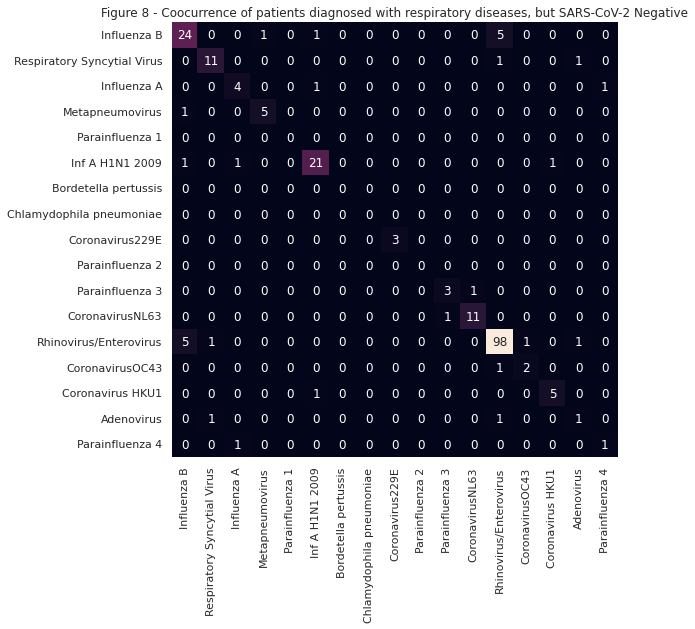

In [70]:
blood_with_respiratory = df5[(df5['regular_blood_tests']==1)&(df5['SARS-Cov-2 exam result']==0)][pcs_vars['respiratory']].dropna()

plt.figure(figsize=(8,8))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.heatmap(blood_with_respiratory.T.dot(blood_with_respiratory),annot=True, cbar=False)
plt.title("Figure 8 - Coocurrence of patients diagnosed with respiratory diseases, but SARS-CoV-2 Negative")

In [71]:
df_InfB = df5[(df5['Influenza B']==1) & (df5['regular_blood_tests']==1) & (df5['SARS-Cov-2 exam result']==0)][pcs_vars['regular_blood']+['Patient age quantile', 'SARS-Cov-2 exam result']].dropna()
X_InfB = df_InfB[pcs_vars['regular_blood']+['Patient age quantile']]
y_InfB = df_InfB['SARS-Cov-2 exam result']

df_H1N1 = df5[(df5['Inf A H1N1 2009']==1) & (df5['regular_blood_tests']==1) & (df5['SARS-Cov-2 exam result']==0)][pcs_vars['regular_blood']+['Patient age quantile', 'SARS-Cov-2 exam result']].dropna()
X_H1N1 = df_H1N1[pcs_vars['regular_blood']+['Patient age quantile']]
y_H1N1 = df_H1N1['SARS-Cov-2 exam result']

df_Rhino = df5[(df5['Rhinovirus/Enterovirus']==1) & (df5['regular_blood_tests']==1) & (df5['SARS-Cov-2 exam result']==0)][pcs_vars['regular_blood']+['Patient age quantile', 'SARS-Cov-2 exam result']].dropna()
X_Rhino = df_Rhino[pcs_vars['regular_blood']+['Patient age quantile']]
y_Rhino = df_Rhino['SARS-Cov-2 exam result']

#### Baseline: Dummy classifiers

Since this dataset is imbalanced, dummy classifiers get high accuracy, but low F1-Score (**0.87** and **0.46**, respectively).

In [72]:
dummy_most_freq_clf = DummyClassifier(strategy="most_frequent")
dummy_most_freq_clf.fit(X_train, y_train)
y_dummy_most_freq_pred = dummy_most_freq_clf.predict(X_test)

print("Classification report for Dummy 'Most Frequent' Classifier")
print(classification_report(y_test, y_dummy_most_freq_pred))

Classification report for Dummy 'Most Frequent' Classifier
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       109
           1       0.00      0.00      0.00        17

    accuracy                           0.87       126
   macro avg       0.43      0.50      0.46       126
weighted avg       0.75      0.87      0.80       126



/home/marco/venvs/covid19env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/venvs/covid19env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/venvs/covid19env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
dummy_strat_clf = DummyClassifier(strategy="stratified")
dummy_strat_clf.fit(X_train, y_train)
y_dummy_strat_pred = dummy_strat_clf.predict(X_test)

print("Classification report for Dummy Stratified Classifier")
print(classification_report(y_test, y_dummy_strat_pred))

Classification report for Dummy Stratified Classifier
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       109
           1       0.14      0.18      0.15        17

    accuracy                           0.74       126
   macro avg       0.50      0.50      0.50       126
weighted avg       0.77      0.74      0.75       126



#### SVM

In [74]:
parameters = {'kernel':('linear', 'rbf'), 
              'C':[0.1, 1, 10],
              'class_weight': [{1: 1}, {1: 2}, {1: 5}, {1: 10}, {1: 15}]
              }

clf = svm.SVC(random_state=42)
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on train: "+"{0:.2%}".format(grid_search.best_score_))


y_pred = grid_search.best_estimator_.predict(X_test)

print("\nClassification report for SVM on test")
print(classification_report(y_test, y_pred))

Best estimator is:{'C': 0.1, 'class_weight': {1: 2}, 'kernel': 'linear'}
F1-Score (macro avg) on train: 80.10%

Classification report for SVM on test
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       109
           1       0.38      0.47      0.42        17

    accuracy                           0.83       126
   macro avg       0.65      0.68      0.66       126
weighted avg       0.84      0.83      0.83       126



#### Gradient Boosting Classifier


In [76]:
parameters = {'n_estimators': [25,50, 100, 150, 200], 
              'max_depth': [3, 5, 10, 15,20,25],
              'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01, 0.001]
              }
model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(model, parameters, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on train: "+"{0:.2%}".format(grid_search.best_score_))

y_pred = grid_search.best_estimator_.predict(X_test)

print("\nClassification report for Gradient Boosting Classifier on test")
print(classification_report(y_test, y_pred))

Best estimator is:{'learning_rate': 1, 'max_depth': 3, 'n_estimators': 50}
F1-Score (macro avg) on train: 73.80%

Classification report for Gradient Boosting Classifier on test
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       109
           1       0.47      0.47      0.47        17

    accuracy                           0.86       126
   macro avg       0.69      0.69      0.69       126
weighted avg       0.86      0.86      0.86       126



Gradient Boosting discussion uses the table below:

In [77]:
pd.DataFrame(grid_search.best_estimator_.feature_importances_,
             index = X_train.columns, columns=['importance']).sort_values('importance',ascending=False)

,importance
Leukocytes,0.424357
Patient age quantile,0.109301
Basophils,0.089973
Eosinophils,0.079134
Monocytes,0.069965
Lymphocytes,0.043688
Red blood cell distribution width (RDW),0.038414
Hemoglobin,0.038212
Mean platelet volume,0.038154
Proteina C reativa mg/dL,0.019629


##### Backtest against Influenza B

In [78]:
#Influenza B
y_pred = grid_search.best_estimator_.predict(X_InfB)
print("\n Accuracy of Gradient Boosting Classifier on Influenza B patients: {:.1f}".format(accuracy_score(y_InfB, y_pred)*100)+"%")


 Accuracy of Gradient Boosting Classifier on Influenza B patients: 100.0%


##### Backtest against H1N1

In [79]:
#H1N1
y_pred = grid_search.best_estimator_.predict(X_H1N1)
print("\n Accuracy of Gradient Boosting Classifier on H1N1 patients: {:.1f}".format(accuracy_score(y_H1N1, y_pred)*100)+"%")


 Accuracy of Gradient Boosting Classifier on H1N1 patients: 86.7%


##### Backtest against Rhinovirus

In [80]:
#Rhinovirus 
y_pred = grid_search.best_estimator_.predict(X_Rhino)
print("\n Accuracy of Gradient Boosting Classifier on Rhinovirus patients: {:.1f}".format(accuracy_score(y_Rhino, y_pred)*100)+"%")


 Accuracy of Gradient Boosting Classifier on Rhinovirus patients: 100.0%


#### Random Forest

In [81]:
parameters = {'n_estimators': [50, 100, 200], 
              'max_depth': [3, 5, 10, 15],
              'max_features': [0.6, 0.8, 1.0],
              'class_weight': [{1: 1}, {1: 2}, {1: 5}, {1: 10}, {1: 15}]
              }

clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on train: "+"{0:.2%}".format(grid_search.best_score_))

y_pred = grid_search.best_estimator_.predict(X_test)

print("\nClassification report for Random Forest on test")
print(classification_report(y_test, y_pred))

Best estimator is:{'class_weight': {1: 10}, 'max_depth': 5, 'max_features': 0.6, 'n_estimators': 50}
F1-Score (macro avg) on train: 78.62%

Classification report for Random Forest on test
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       109
           1       0.40      0.47      0.43        17

    accuracy                           0.83       126
   macro avg       0.66      0.68      0.67       126
weighted avg       0.85      0.83      0.84       126



#### AdaBoost (on Decision Trees)

In [82]:
parameters = {'n_estimators': [5, 10, 20, 30], 
              'base_estimator': [DecisionTreeClassifier(max_depth=1),
                                 DecisionTreeClassifier(max_depth=3),
                                 DecisionTreeClassifier(max_depth=1, class_weight="balanced"),
                                 DecisionTreeClassifier(max_depth=3, class_weight="balanced")],
              'learning_rate': [0.01, 0.1, 1.0]
              }

clf = AdaBoostClassifier(random_state=42)
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on train: "+"{0:.2%}".format(grid_search.best_score_))

y_pred = grid_search.best_estimator_.predict(X_test)

print("\nClassification report for AdaBoost on test")
print(classification_report(y_test, y_pred))

Best estimator is:{'base_estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=1), 'learning_rate': 0.1, 'n_estimators': 30}
F1-Score (macro avg) on train: 74.35%

Classification report for AdaBoost on test
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       109
           1       0.34      0.65      0.45        17

    accuracy                           0.79       126
   macro avg       0.64      0.73      0.66       126
weighted avg       0.86      0.79      0.81       126



The plot below is used in the discussion of AdaBoost results.

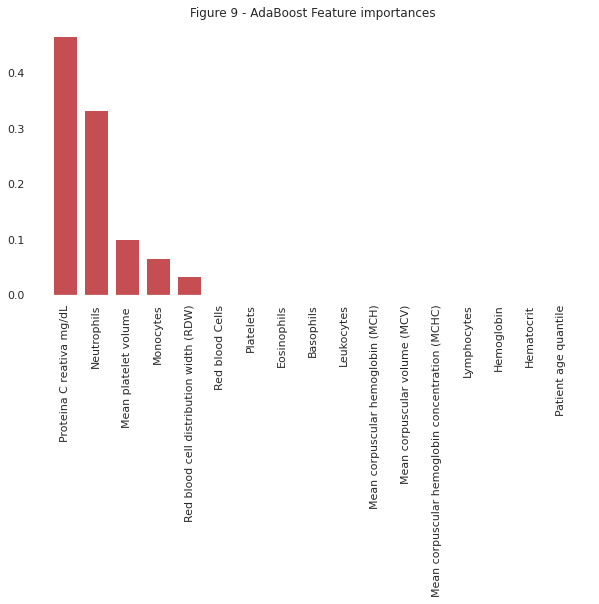

Feature ranking:
1. Proteina C reativa mg/dL (0.466667)
2. Neutrophils (0.333333)
3. Mean platelet volume  (0.100000)
4. Monocytes (0.066667)
5. Red blood cell distribution width (RDW) (0.033333)
6. Red blood Cells (0.000000)
7. Platelets (0.000000)
8. Eosinophils (0.000000)
9. Basophils (0.000000)
10. Leukocytes (0.000000)
11. Mean corpuscular hemoglobin (MCH) (0.000000)
12. Mean corpuscular volume (MCV) (0.000000)
13. Mean corpuscular hemoglobin concentration (MCHC) (0.000000)
14. Lymphocytes (0.000000)
15. Hemoglobin (0.000000)
16. Hematocrit (0.000000)
17. Patient age quantile (0.000000)


In [83]:
importances = grid_search.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in grid_search.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(10,5))
plt.title("Figure 9 - AdaBoost Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), X_train.columns, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[f], importances[indices[f]]))


##### Backtest against Influenza B

In [84]:
#Influenza B
y_pred = grid_search.best_estimator_.predict(X_InfB)
print("\n Accuracy of Ada Boost Classifier on Influenza B patients: {:.1f}".format(accuracy_score(y_InfB, y_pred)*100)+"%")


 Accuracy of Ada Boost Classifier on Influenza B patients: 53.8%


##### Backtest against H1N1

In [85]:
#H1N1
y_pred = grid_search.best_estimator_.predict(X_H1N1)
print("\n Accuracy of Ada Boost Classifier on H1N1 patients: {:.1f}".format(accuracy_score(y_H1N1, y_pred)*100)+"%")


 Accuracy of Ada Boost Classifier on H1N1 patients: 80.0%


##### Backtest against Rhinovirus

In [86]:
#Rhinovirus 
y_pred = grid_search.best_estimator_.predict(X_Rhino)
print("\n Accuracy of Ada Boost Classifier on Rhinovirus patients: {:.1f}".format(accuracy_score(y_Rhino, y_pred)*100)+"%")


 Accuracy of Ada Boost Classifier on Rhinovirus patients: 94.4%


### Respiratory virus and bacteria Tests

This group of tests is composed of the patient age quantile and 17 tests on common virus and bacterias that affect the respiratory system, such as H1N1 and influenza. **The models fitted to this subset of tests barely outperformed the baseline.** One curious case was the Random Forest algorithm that reached a 65% F1-Score on test, but greatly deviated from validation results (55%), so we invalidated the model. Investigatint the feature importances of this random forest we've found that 48% of the model was explained by patient age, which is far from reasonable.

In [87]:
selected_vars = ['SARS-Cov-2 exam result', 'unit', 'Patient age quantile'] + pcs_vars['respiratory']
df_respiratory = df5[selected_vars].dropna() #Shape: (420, 19)

X = df_respiratory[pcs_vars['respiratory']+['Patient age quantile']]
y = df_respiratory['SARS-Cov-2 exam result']
strat = df_respiratory['SARS-Cov-2 exam result'].astype(str) + df_respiratory['unit'] #stratification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=strat, shuffle=True, random_state=42)
#X_train.shape: (946, 18)
#X_test.shape: (406, 18)

#### Baseline: Dummy classifiers

Since this dataset is imbalanced, dummy classifiers get high accuracy, but low F1-Score (**0.92** and **0.48**, respectively).

In [88]:
dummy_most_freq_clf = DummyClassifier(strategy="most_frequent")
dummy_most_freq_clf.fit(X_train, y_train)
y_dummy_most_freq_pred = dummy_most_freq_clf.predict(X_test)

print("Classification report for Dummy 'Most Frequent' Classifier")
print(classification_report(y_test, y_dummy_most_freq_pred))

Classification report for Dummy 'Most Frequent' Classifier
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       372
           1       0.00      0.00      0.00        34

    accuracy                           0.92       406
   macro avg       0.46      0.50      0.48       406
weighted avg       0.84      0.92      0.88       406



/home/marco/venvs/covid19env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/venvs/covid19env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/venvs/covid19env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:
dummy_strat_clf = DummyClassifier(strategy="stratified")
dummy_strat_clf.fit(X_train, y_train)
y_dummy_strat_pred = dummy_strat_clf.predict(X_test)

print("Classification report for Dummy Stratified Classifier")
print(classification_report(y_test, y_dummy_strat_pred))

Classification report for Dummy Stratified Classifier
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       372
           1       0.15      0.15      0.15        34

    accuracy                           0.86       406
   macro avg       0.54      0.54      0.54       406
weighted avg       0.86      0.86      0.86       406



#### SVM

In [90]:
parameters = {'kernel':('linear', 'rbf'), 
              'C':[0.1, 1, 10],
              'class_weight': [{1: 1}, {1: 2}, {1: 5}, {1: 10}, {1: 15}]
              }

clf = svm.SVC(random_state=42)
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on train: "+"{0:.2%}".format(grid_search.best_score_))

y_pred = grid_search.best_estimator_.predict(X_test)

print("\nClassification report for SVM on test")
print(classification_report(y_test, y_pred))

Best estimator is:{'C': 10, 'class_weight': {1: 5}, 'kernel': 'linear'}
F1-Score (macro avg) on train: 52.28%

Classification report for SVM on test
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       372
           1       0.00      0.00      0.00        34

    accuracy                           0.92       406
   macro avg       0.46      0.50      0.48       406
weighted avg       0.84      0.92      0.88       406



/home/marco/venvs/covid19env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/venvs/covid19env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/venvs/covid19env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Gradient Boosting Classifier


In [91]:
parameters = {'n_estimators': [25,50, 100, 150, 200], 
              'max_depth': [3, 5, 10, 15,20,25],
              'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01, 0.001]
              }
model = GradientBoostingClassifier()
grid_search = GridSearchCV(model, parameters, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on train: "+"{0:.2%}".format(grid_search.best_score_))

y_pred = grid_search.best_estimator_.predict(X_test)

print("\nClassification report for Gradient Boosting Classifier on test")
print(classification_report(y_test, y_pred))

Best estimator is:{'learning_rate': 0.25, 'max_depth': 3, 'n_estimators': 25}
F1-Score (macro avg) on train: 47.85%

Classification report for Gradient Boosting Classifier on test
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       372
           1       0.00      0.00      0.00        34

    accuracy                           0.92       406
   macro avg       0.46      0.50      0.48       406
weighted avg       0.84      0.92      0.88       406



/home/marco/venvs/covid19env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/venvs/covid19env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/venvs/covid19env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Random Forest

In [92]:
parameters = {'n_estimators': [50, 100, 200], 
              'max_depth': [3, 5, 10, 15],
              'max_features': [0.6, 0.8, 1.0],
              'class_weight': [{1: 1}, {1: 2}, {1: 5}, {1: 10}, {1: 15}]
              }

clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on train: "+"{0:.2%}".format(grid_search.best_score_))

y_pred = grid_search.best_estimator_.predict(X_test)

print("\nClassification report for Random Forest on test")
print(classification_report(y_test, y_pred))

Best estimator is:{'class_weight': {1: 5}, 'max_depth': 15, 'max_features': 0.6, 'n_estimators': 100}
F1-Score (macro avg) on train: 57.28%

Classification report for Random Forest on test
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       372
           1       0.23      0.47      0.30        34

    accuracy                           0.82       406
   macro avg       0.59      0.66      0.60       406
weighted avg       0.89      0.82      0.85       406



The discussion on this result uses the feature importance table below.

In [93]:
pd.DataFrame(grid_search.best_estimator_.feature_importances_,
             index = X_train.columns, columns=['importance']).sort_values('importance',ascending=False)

,importance
Patient age quantile,0.450999
Rhinovirus/Enterovirus,0.199118
Inf A H1N1 2009,0.076063
Influenza B,0.072149
CoronavirusNL63,0.060652
Coronavirus HKU1,0.029366
Coronavirus229E,0.022757
Influenza A,0.019526
Respiratory Syncytial Virus,0.018941
Metapneumovirus,0.013126


#### AdaBoost (on Decision Trees)

In [94]:
parameters = {'n_estimators': [5, 10, 20, 30], 
              'base_estimator': [DecisionTreeClassifier(max_depth=1),
                                 DecisionTreeClassifier(max_depth=3),
                                 DecisionTreeClassifier(max_depth=1, class_weight="balanced"),
                                 DecisionTreeClassifier(max_depth=3, class_weight="balanced")],
              'learning_rate': [0.01, 0.1, 1.0]
              }

clf = AdaBoostClassifier(random_state=42)
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on train: "+"{0:.2%}".format(grid_search.best_score_))

y_pred = grid_search.best_estimator_.predict(X_test)

print("\nClassification report for Random Forest on test")
print(classification_report(y_test, y_pred))

Best estimator is:{'base_estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 1.0, 'n_estimators': 10}
F1-Score (macro avg) on train: 51.21%

Classification report for Random Forest on test
              precision    recall  f1-score   support

           0       0.98      0.60      0.75       372
           1       0.17      0.88      0.28        34

    accuracy                           0.63       406
   macro avg       0.58      0.74      0.51       406
weighted avg       0.91      0.63      0.71       406



### Influenza Rapid Tests

The influenza rapid tests group is composed of 2 tests (A and B Influenza rapid tests) and the patient age quantile. It has 820 samples. **The models fitted to it marginally outperformed the baseline**. Testing positive or not apparently doesn't help on diagnosing coronavirus.

In [95]:
selected_vars = ['SARS-Cov-2 exam result', 'unit', 'Patient age quantile'] + pcs_vars['influenza_rapid']
df_influenza = df5[selected_vars].dropna() #Shape: (820, 5)

X = df_influenza[pcs_vars['influenza_rapid']+['Patient age quantile']]
y = df_influenza['SARS-Cov-2 exam result']
strat = df_influenza['SARS-Cov-2 exam result'].astype(str) + df_influenza['unit'] #stratification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=strat, shuffle=True, random_state=42)
#X_train.shape: (574, 3)
#X_test.shape: (246, 3)

#### Baseline: Dummy classifiers

Since this dataset is imbalanced, dummy classifiers get high accuracy, but low F1-Score (**0.92** and **0.48**, respectively).

In [96]:
dummy_most_freq_clf = DummyClassifier(strategy="most_frequent")
dummy_most_freq_clf.fit(X_train, y_train)
y_dummy_most_freq_pred = dummy_most_freq_clf.predict(X_test)

print("Classification report for Dummy 'Most Frequent' Classifier")
print(classification_report(y_test, y_dummy_most_freq_pred))

Classification report for Dummy 'Most Frequent' Classifier
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       227
           1       0.00      0.00      0.00        19

    accuracy                           0.92       246
   macro avg       0.46      0.50      0.48       246
weighted avg       0.85      0.92      0.89       246



/home/marco/venvs/covid19env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/venvs/covid19env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/venvs/covid19env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [97]:
dummy_strat_clf = DummyClassifier(strategy="stratified")
dummy_strat_clf.fit(X_train, y_train)
y_dummy_strat_pred = dummy_strat_clf.predict(X_test)

print("Classification report for Dummy Stratified Classifier")
print(classification_report(y_test, y_dummy_strat_pred))

Classification report for Dummy Stratified Classifier
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       227
           1       0.10      0.11      0.10        19

    accuracy                           0.85       246
   macro avg       0.51      0.51      0.51       246
weighted avg       0.86      0.85      0.86       246



#### SVM

In [98]:
parameters = {'kernel':('linear', 'rbf'), 
              'C':[0.01, 0.1, 1, 10],
              'class_weight': [{1: 1}, {1: 2}, {1: 5}, {1: 10}, {1: 15}]
              }

clf = svm.SVC(random_state=42)
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on train: "+"{0:.2%}".format(grid_search.best_score_))

y_pred = grid_search.best_estimator_.predict(X_test)

print("\nClassification report for SVM on test")
print(classification_report(y_test, y_pred))

Best estimator is:{'C': 1, 'class_weight': {1: 10}, 'kernel': 'linear'}
F1-Score (macro avg) on train: 49.00%

Classification report for SVM on test
              precision    recall  f1-score   support

           0       0.95      0.62      0.75       227
           1       0.11      0.58      0.19        19

    accuracy                           0.61       246
   macro avg       0.53      0.60      0.47       246
weighted avg       0.88      0.61      0.70       246



#### Gradient Boosting Classifier


In [103]:
parameters = {'n_estimators': [25,50, 100, 150, 200], 
              'max_depth': [3, 5, 10, 15,20,25],
              'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01, 0.001]
              }
model = GradientBoostingClassifier()
grid_search = GridSearchCV(model, parameters, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on train: "+"{0:.2%}".format(grid_search.best_score_))

y_pred = grid_search.best_estimator_.predict(X_test)

print("\nClassification report for Gradient Boosting Classifier on test")
print(classification_report(y_test, y_pred))

Best estimator is:{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 25}
F1-Score (macro avg) on train: 48.05%

Classification report for Gradient Boosting Classifier on test
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       227
           1       0.00      0.00      0.00        19

    accuracy                           0.92       246
   macro avg       0.46      0.50      0.48       246
weighted avg       0.85      0.92      0.89       246



/home/marco/venvs/covid19env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/venvs/covid19env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marco/venvs/covid19env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Random Forest

In [104]:
parameters = {'n_estimators': [50, 100, 200], 
              'max_depth': [3, 5, 10, 15],
              'max_features': [0.6, 0.8, 1.0],
              'class_weight': [{1: 1}, {1: 2}, {1: 5}, {1: 10}, {1: 15}]
              }

clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on train: "+"{0:.2%}".format(grid_search.best_score_))

y_pred = grid_search.best_estimator_.predict(X_test)

print("\nClassification report for Random Forest on test")
print(classification_report(y_test, y_pred))

Best estimator is:{'class_weight': {1: 10}, 'max_depth': 10, 'max_features': 0.6, 'n_estimators': 100}
F1-Score (macro avg) on train: 56.41%

Classification report for Random Forest on test
              precision    recall  f1-score   support

           0       0.94      0.72      0.81       227
           1       0.11      0.42      0.18        19

    accuracy                           0.70       246
   macro avg       0.52      0.57      0.49       246
weighted avg       0.87      0.70      0.76       246



#### AdaBoost (on Decision Trees)

In [105]:
parameters = {'n_estimators': [5, 10, 20, 30], 
              'base_estimator': [DecisionTreeClassifier(max_depth=1),
                                 DecisionTreeClassifier(max_depth=3),
                                 DecisionTreeClassifier(max_depth=1, class_weight="balanced"),
                                 DecisionTreeClassifier(max_depth=3, class_weight="balanced")],
              'learning_rate': [0.01, 0.1, 1.0]
              }

clf = AdaBoostClassifier(random_state=42)
grid_search = GridSearchCV(clf, parameters, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print("Best estimator is:"+str(grid_search.best_params_))
print("F1-Score (macro avg) on train: "+"{0:.2%}".format(grid_search.best_score_))

y_pred = grid_search.best_estimator_.predict(X_test)

print("\nClassification report for Random Forest on test")
print(classification_report(y_test, y_pred))

Best estimator is:{'base_estimator': DecisionTreeClassifier(class_weight='balanced', max_depth=3), 'learning_rate': 1.0, 'n_estimators': 10}
F1-Score (macro avg) on train: 51.41%

Classification report for Random Forest on test
              precision    recall  f1-score   support

           0       0.95      0.62      0.75       227
           1       0.12      0.63      0.21        19

    accuracy                           0.62       246
   macro avg       0.54      0.63      0.48       246
weighted avg       0.89      0.62      0.71       246



In [106]:
from joblib import dump
dump(clf, 'cov19model.joblib') 

['cov19model.joblib']

## Final thoughts on results

The Gradient Boosting Classifier is the best alternative we've got for high precision needs. We believe though that recall is preferred over precision given the efficacy of putting infected people in isolation.

We identified some possible bias in the data that must be taking into account when modelling it, specially that some tests are performed mostly on severe cases. We also were capable of spliting the dataset into 6 groups of frequently co-occuring medical exams in a unsupervised manner, which allowed for greater samples on training (less dropping of records due to null values). 

We also showed that the blood tests are the only relevant exams found to greatly outperform a dummy baseline in predicting coranavirus. The unbalanaced nature of the data was explored and taken into account when evaluating the model performances. The accuracy of the models were tested against patients with 3 diseases which have similar symptoms to COVID-19 and the results suggested that they can differentiate SARS-CoV-2 from H1N1, Rhinovirus and Influenza B.

Finally, **AdaBoost is our model of choice for isolation of suspicious cases**, since it  has a very high recall. As exemplified by the video below by Grant Sanderson, adopting strategies to quickly isolate vectors of a disease is the most effective (non-pharmacological) strategy.

In [102]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/gxAaO2rsdIs" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/home/marco/venvs/covid19env/lib/python3.6/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Acknowledgment

We would like to thanks the team from Einstein Data4u for the competition and selection of our work as relevant to the theme. We also thanks SIG Ciência de Dados & Inteligência Artificial em Saúde (CIDIAS) for the opportunity to present our work to a medical audience.

## Referências

1. Milton Ossamu Tanizaka. **Exploratory Data Analysis and Feature Importance.** Kernel on Kaggle. Available at: https://www.kaggle.com/ossamum/exploratory-data-analysis-and-feature-importance
2. Nasser Boan. **null_values_exploration + logreg**. Kernel on Kaggle. Available at: https://www.kaggle.com/nazeboan/null-values-exploration-logreg-67-acc
3. Blann A. **Routine blood tests 1: why do we test for urea and electrolytes?** Nursing Times; 110: 5, 19-21. 2014. Available at: https://www.nursingtimes.net/clinical-archive/assessment-skills/why-do-we-test-for-urea-and-electrolytes-24-01-2014/
4. Andrew Gonzalez, MD. **Red Cell Distribution Width (RDW) Test**. Healthline. Available at: https://www.healthline.com/health/rdw-blood-test
5. Nardocci Paula, Gullo Caio Eduardo, Lobo Suzana Margareth. **Severe virus influenza A H1N1 related pneumonia and community-acquired pneumonia: differences in the evolution.** Rev. bras. ter. intensiva  [Internet]. 2013  June;  25( 2 ): 123-129. Available from: http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0103-507X2013000200010&lng=en.  https://doi.org/10.5935/0103-507X.20130023.
6. J. Matthew Velkey. **Cell Injury, Death, Inflammation, and Repair**. Lecture notes. Duke University. Available at: https://slideplayer.com/slide/4382692/
